# A - Cumulative subducted carbon

Produce grids of cumulative subducted from each contribution of:

- Sediment
- Serpentinite
- Crust
- Lithosphere

through time.

The previous notebook __Subducted Carbon.ipynb__ must be run before this notebook. 

### Note: To save the outputs in this notebook once, the chosen hard drive requires at least 150 GB of free storage.

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import joblib
import numpy as np
import pygplates
import os, glob
os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"
import gplately
import gplately.grids as grids
import gplately.tools as tools
import gplately.ptt as ptt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
from scipy import ndimage
import pandas as pd
from slabdip import SlabDipper
import numpy.ma as ma
%matplotlib inline
# plt.style.use('ggplot')

#from pygplates_helper import *

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1800
timestep_size = 1

# time array
# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(max_time, min_time-timestep_size, -timestep_size)




# OUTPUT SAVING TOGGLES
save_output_netcdf = True # !! important
save_output_snapshots = False

# This is to save outputs from the parallelised "carbon_subducted_and_accreted" routine
save_outputs_to_csv = True

os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"

### Ensure all needed output paths are created
Change `folder_name` to keep track of results of Notebook 03 reruns

In [2]:
save_cumulative_subducted_carbon = True
save_smoothed_timestep_grid = True
save_smoothed_cumulative_grid = True

# Save the sum of crust + lithosphere + serpentinite
save_mantle_cumulative_subducted_carbon = True

In [3]:
# --------------- Everything below here can be kept as-is ----------------
# FOR CUMULATIVE SUBDUCTED CARBON PER TIMESTEP
output_cumulative_subducted_carbon_grid_directory = "../Grids/cumulative_subducted_carbon/{}/{}/"

for storage in ['Lithosphere', 'Serpentinite', 'Crust', 'Sediment', 'Mantle', 'Organic_Sediments']:
    for quantity in ['min', 'mean', 'max']:
        os.makedirs(output_cumulative_subducted_carbon_grid_directory.format(storage, quantity), exist_ok=True)

Define gplately's `PlateReconstruction` and `PlotTopologies` objects.

In [5]:
# Location of Cao2024 1.8Ga plate model.
model_dir = "./Cao_etal_2024_1.8_Ga_mantle_ref_frame"
# Rotation files (relative to input directory).
rotation_features = [
    model_dir+'/optimisation/1800_1000_rotfile_20240725.rot',
    model_dir+'/optimisation/1000_0_rotfile_20240725.rot',
]

# Topology features (absolute file paths).
# Only include those GPML files that are used for topologies.
topology_features = [
    model_dir+'/1800-1000_plate_boundaries.gpml',
    model_dir+'/250-0_plate_boundaries.gpml',
    model_dir+'/410-250_plate_boundaries.gpml',
    model_dir+'/1000-410-Convergence.gpml',
    model_dir+'/1000-410-Divergence.gpml',
    model_dir+'/1000-410-plate-boundaries.gpml',
    model_dir+'/1000-410-Transforms.gpml',
    model_dir+'/TopologyBuildingBlocks.gpml',
]
# Continent polygon features (absolute file paths).
continent_features = [
    model_dir+'/shapes_continents.gpmlz',
]


# Pass filenames into gplately objects
model = gplately.PlateReconstruction(rotation_model=rotation_features, topology_features=topology_features)
gplot = gplately.PlotTopologies(model, continents=continent_features)

In [6]:
print(gplot.continents)

None


In [6]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

## Make rasters of cumulative subducted carbon

### Build the `cumulative_subducted_carbon` array
If `save_output_netcdf` was set to `True` in Notebook `02-Subducted-Carbon.ipynb`, masked arrays of total global subducted carbon per timestep would have been saved to a netCDF4 grid. All grid nodes with no subducted carbon are given NaN entries.

In the cells below, we loop through time to collect the carbon subducted for each carbon storage reservoir and quantity. At each time step, we append the current contribution to an array, `cumulative_subducted_carbon` for a given component and quantity. Every timestep we save the current cumulative subducted carbon grid to a netcdf file.

To make this process faster, it is performed using parallelisation with `joblib`. The process is made more memory-friendly by partitioning the time array (and thus the parallel tasks) into groups of times. 

In [7]:
# Define carbon quantities and components
carbon_components = ["Sediment", "Serpentinite", "Crust", "Lithosphere", "Organic_Sediments"]
quantities = ["min", "mean", "max"]

# Define path to the subducted carbon contributions per timestep
subducted_carbon_grid_filename = "../Grids/subducted_carbon/{}/{}/subducted_carbon_{}_{}.nc"

### Function to smooth subducted carbon contribution grids with `scipy.ndimage`'s `fourier_gaussian()` filter
...which we access from an outsourced utility script `fft_gaussian_filter.py` in the `/utils/` directory.

In [9]:
if save_smoothed_timestep_grid:
    
    import sys
    sys.path.insert(0, './utils/')

    import fft_gaussian_filter as fft_gaussian_filter_script

    def gaussian_smooth_grid(data, distance_km):
   
        """ Smooth grids using a Gaussian. 
        If input grid comes with a mask, all masked values are retained. 
        """
        mask = np.isnan(data)
        smoothed_grid = fft_gaussian_filter_script.fft_gaussian_filter(data, distance_km)
        smoothed_grid[mask] = np.nan
        return smoothed_grid

Select a Gaussian filter width (km) and produce a save directory for all cumulative grids with this smoothing filter width.

In [8]:
distance_km = 300

# Define path to the cumulative subducted carbon grid we will make in this cell
output_cumulative_subducted_carbon_filename = "../Grids/cumulative_subducted_carbon/{}/{}/cumulative_subducted_carbon_{}_{}.nc"
output_smooth_cumulative_subducted_carbon_grid_directory = "../Grids/smoothed_cumulative_subducted_carbon/{}km/{}/{}/"
output_smooth_cumulative_subducted_carbon_filename = output_smooth_cumulative_subducted_carbon_grid_directory+"cumulative_subducted_carbon_{}_{}.nc"

for storage in ['Mantle', 'Sediment', 'Crust', "Organic_Sediments"]:
    for quantity in ['min', 'mean', 'max']:
        os.makedirs(output_smooth_cumulative_subducted_carbon_grid_directory.format(distance_km, storage, quantity), exist_ok=True)
        
        
output_smoothed_subducted_carbon_grid_directory = "../Grids/smoothed_subducted_carbon/{}km/{}/{}/"
smoothed_subducted_carbon_grid_filename = output_smoothed_subducted_carbon_grid_directory+"subducted_carbon_{}_{}.nc"
for storage in ['Lithosphere', 'Serpentinite', 'Crust', 'Sediment', 'Organic_Sediments']:
    for quantity in ['min', 'mean', 'max']:
        os.makedirs(output_smoothed_subducted_carbon_grid_directory.format(distance_km, storage, quantity), exist_ok=True)

### Accumulate grids in parallel, save to netCDF in a single core 

In [10]:
def accumulate_subducted_carbon(component, reconstruction_time, distance_km=300):
    
    # Store cumulative subducted carbon from the grids in a numpy array
    subducted_carbon_components = np.zeros((3, resY, resX))
    smoothed_subducted_carbon_components = np.zeros((3, resY, resX))

    for i, quantity in enumerate(quantities):

        subducted_carbon_filename = subducted_carbon_grid_filename.format(
             component, quantity, component.lower(), reconstruction_time
        )

        # Read the masked subducted carbon contribution array for the current time
        current_time_grid = grids.read_netcdf_grid(subducted_carbon_filename)

        # Get the data array, and fill all NaNs with 0s.
        current_time_grid = np.nan_to_num(current_time_grid.data)
        
        current_time_grid_filled = grids.fill_raster(current_time_grid)
        subducted_carbon_components[i] = current_time_grid_filled

        # If the user wants the smoothed piecewise grids to be returned,
        if save_smoothed_timestep_grid:

            
            # Define the filename for saving the smoothed grids
            smoothed_filename = smoothed_subducted_carbon_grid_filename.format(
                     distance_km, component, quantity, component.lower(), reconstruction_time
            )
            # Smooth the grids
            smoothed_current_time_grid = gaussian_smooth_grid(
                current_time_grid_filled,
                
                distance_km=distance_km
            )
            # Read in the smoothed grid, fill the raster, and return
            smoothed_current_time_grid_filled = grids.fill_raster(smoothed_current_time_grid)
            smoothed_subducted_carbon_components[i] += smoothed_current_time_grid_filled
            
            # Create a mask for the interpolated grid - all values with 0s need to have an equivalent
            # mask value of NaN. 
            smoothed_current_time_grid_filled_masked = ma.masked_array(smoothed_current_time_grid_filled)
            smoothed_current_time_grid_filled_masked = ma.masked_values(smoothed_current_time_grid_filled_masked, 0.0)
            smoothed_current_time_grid_filled_masked.fill_value = np.nan
            
            current_subducted_carbon_smoothed = np.ma.array(
                    smoothed_subducted_carbon_components[i],
                    mask = smoothed_current_time_grid_filled_masked.mask,
                    fill_value=np.nan
                )
            
            grids.write_netcdf_grid(
                smoothed_filename,
                current_subducted_carbon_smoothed
            )

    if save_smoothed_timestep_grid:
        return subducted_carbon_components, reconstruction_time, smoothed_current_time_grid_filled, smoothed_filename
    else:
        return subducted_carbon_components, reconstruction_time

        
def accumulate_smoothed_mantle_grids(reconstruction_time, distance_km=300):
    
    # Store cumulative subducted carbon from the grids in a numpy array
    smoothed_subducted_carbon_components = np.zeros((3, resY, resX))

    for i, quantity in enumerate(quantities):
        for c, component in enumerate(["Lithosphere", "Crust", "Serpentinite"]):

            subducted_carbon_filename = smoothed_subducted_carbon_grid_filename.format(
                 distance_km, component, quantity, component.lower(), reconstruction_time
            )

            current_time_grid = grids.read_netcdf_grid(subducted_carbon_filename)
            # Get the data array, and fill all NaNs with 0s.
            current_time_grid = np.nan_to_num(current_time_grid.data)
            current_time_grid_filled = grids.fill_raster(current_time_grid)

            # For the current time, we have a 3 by resY by resX grid. Each dimension in
            # axis 0 is the sum of all crust, serpentinite and lithosphere in the 
            # min, mean and max (respectively)
            smoothed_subducted_carbon_components[i] += current_time_grid_filled

    return smoothed_subducted_carbon_components


def accumulate_reservoir_grids(reconstruction_time, component, distance_km=300):
    
    # Store cumulative subducted carbon from the grids in a numpy array
    smoothed_subducted_carbon_components = np.zeros((3, resY, resX))

    for i, quantity in enumerate(quantities):

        subducted_carbon_filename = smoothed_subducted_carbon_grid_filename.format(
             distance_km, component, quantity, component.lower(), reconstruction_time
        )

        current_time_grid = grids.read_netcdf_grid(subducted_carbon_filename)
        # Get the data array, and fill all NaNs with 0s.
        current_time_grid = np.nan_to_num(current_time_grid.data)
        current_time_grid_filled = grids.fill_raster(current_time_grid)

        # For the current time, we have a 3 by resY by resX grid. Each dimension in
        # axis 0 is the current reservoir subducted carbon grid in min, mean and max (respectively)
        smoothed_subducted_carbon_components[i] += current_time_grid_filled

    return smoothed_subducted_carbon_components

## Accumulate grids in parallel...

This cell can get memory-intensive. We can relieve memory pressure by setting `time_splitter_integer` to a smaller value. It can be 0, or negative. The smaller the value, the smaller the chunks of timesteps used for accumulation.

In [11]:
time_splitter_integer = -5

In [12]:
with Parallel(n_jobs=-3, verbose=1) as parallel:
    cumulative_subducted_carbon = np.zeros((len(carbon_components), 3, resY, resX))
    smoothed_cumulative_subducted_carbon = np.zeros((len(carbon_components), 3, resY, resX))
    total_smoothed_cumulative_mantle = np.zeros((3, resY, resX))
    
    # Split the time array into groups of timesteps
    split_times = np.array_split(reconstruction_times, cpu_count() - time_splitter_integer)
    
    # Start counting current time from min_time
    curr_time = min_time
    
    # Loop through each time array. get a group of subducted carbon contributions
    for times in split_times:
        for c, component in enumerate(carbon_components):
            
            if component == "Sediment" and times[-1] > 170.:
                continue
                
            if component == "Organic_Sediments" and times[-1] > 540.:
                continue
            
            print("Accumulating {} grids from {} to {}Ma...".format(component, times[0], times[-1]))
            
            # Accumulate raw carbon grids, and simultaneously smooth the individual contributions.
            results = parallel(delayed(accumulate_subducted_carbon)(
                component, 
                time,
                distance_km=distance_km
            ) 
               for time in times
            )

            results = np.array(results, dtype=object)

            carbon_subducted = results[:,0]
            curr_times = results[:,1]
            
            if save_smoothed_timestep_grid:
                print("Smoothed {} grids from {} to {}Ma, saving grids now...".format(component, times[0], times[-1]))
                smoothed_carbon_subducted = results[:,2]

            # For each time index and result in the current result array,
            for t, subducted_carbon_components in enumerate(carbon_subducted):
                
                # We have one array per timestep with 3 entries for min, mean and max. 
                # print(component, t, len(subducted_carbon_components)) 
                if save_cumulative_subducted_carbon:
                    cumulative_subducted_carbon[c] += subducted_carbon_components 
                
                # Repeat for the smoothed subducted carbon piecewise grids if saving smoothed grids. 
                if save_smoothed_cumulative_grid:
                    smoothed_cumulative_subducted_carbon[c] += smoothed_carbon_subducted[t]
                    
                
                for q, quantity in enumerate(quantities):
                    
                    # Save the raw cumulative subducted carbon grid. 
                    if save_cumulative_subducted_carbon:
                        
                        # Make the mask
                        cumulative_subducted_carbon_curr = ma.masked_array(cumulative_subducted_carbon[c,q])
                        cumulative_subducted_carbon_curr = ma.masked_values(cumulative_subducted_carbon_curr, 0.0)
                        cumulative_subducted_carbon_curr.fill_value = np.nan

                        current_cumulative_subducted_carbon = np.ma.array(
                                cumulative_subducted_carbon[c,q],
                                mask = cumulative_subducted_carbon_curr.mask,
                                fill_value=np.nan
                            )
                        
                        gplately.grids.write_netcdf_grid(
                            output_cumulative_subducted_carbon_filename.format(
                                 
                                component, 
                                quantity, 
                                component.lower(), 
                                curr_times[t]
                            ), 
                            current_cumulative_subducted_carbon
                        )
                        
                    # Save the smoothed cumulative subducted carbon grid if sediment.
                    if component == "Sediment" or component == "Organic_Sediments":
                        if save_smoothed_cumulative_grid: 
                            
                            # Make the mask
                            cumulative_sediment = ma.masked_array(smoothed_cumulative_subducted_carbon[c,q])
                            cumulative_sediment = ma.masked_values(cumulative_sediment, 0.0)
                            cumulative_sediment.fill_value = np.nan

                            current_cumulative_subducted_sediment = np.ma.array(
                                    smoothed_cumulative_subducted_carbon[c,q],
                                    mask = cumulative_sediment.mask,
                                    fill_value=np.nan
                                )
                        
                            gplately.grids.write_netcdf_grid(
                                output_smooth_cumulative_subducted_carbon_filename.format(
                                     
                                    distance_km,
                                    component, 
                                    quantity, 
                                    component.lower(), 
                                    curr_times[t]
                                ), 
                                current_cumulative_subducted_sediment
                            )
                            
        if save_mantle_cumulative_subducted_carbon:

            mantle_results = parallel(delayed(accumulate_smoothed_mantle_grids)(time, distance_km) for time in times)
            mantle_results_arr = np.array(mantle_results, dtype=object)
            mantle_cumulative_results = mantle_results_arr[:,0]
            
            print("Saving mantle grids (lithosphere + crust + serpentinite) from {} to {}Ma...".format(times[0], times[-1]))
            
            for t, curr_time_mantle_carbon in enumerate(mantle_cumulative_results):
                
                curr_time_mantle_carbon = curr_time_mantle_carbon.astype(dtype=float)
                total_smoothed_cumulative_mantle += curr_time_mantle_carbon
                
                for q, quantity in enumerate(quantities):
                    
                    current_mantle = total_smoothed_cumulative_mantle[q,:]
                    current_mantle_filled = grids.fill_raster(current_mantle)

                    # Save the smoothed cumulative subducted carbon grid. 
                    gplately.grids.write_netcdf_grid(
                        output_smooth_cumulative_subducted_carbon_filename.format(
                             
                            distance_km,
                            "Mantle", 
                            quantity, 
                            "Mantle".lower(), 
                            times[t]
                        ), 
                        current_mantle_filled
                    )
                    
        
os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"                    

Accumulating Serpentinite grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   38.3s finished
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.


Smoothed Serpentinite grids from 1800 to 1680Ma, saving grids now...
Accumulating Crust grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   37.1s finished


Smoothed Crust grids from 1800 to 1680Ma, saving grids now...
Accumulating Lithosphere grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   37.2s finished


Smoothed Lithosphere grids from 1800 to 1680Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   27.8s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1800 to 1680Ma...
Accumulating Serpentinite grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   38.5s finished


Smoothed Serpentinite grids from 1679 to 1560Ma, saving grids now...
Accumulating Crust grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.2s finished


Smoothed Crust grids from 1679 to 1560Ma, saving grids now...
Accumulating Lithosphere grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   35.5s finished


Smoothed Lithosphere grids from 1679 to 1560Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   24.6s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1679 to 1560Ma...
Accumulating Serpentinite grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.1s finished


Smoothed Serpentinite grids from 1559 to 1440Ma, saving grids now...
Accumulating Crust grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.0s finished


Smoothed Crust grids from 1559 to 1440Ma, saving grids now...
Accumulating Lithosphere grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.4s finished


Smoothed Lithosphere grids from 1559 to 1440Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   22.2s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1559 to 1440Ma...
Accumulating Serpentinite grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   35.7s finished


Smoothed Serpentinite grids from 1439 to 1320Ma, saving grids now...
Accumulating Crust grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   35.8s finished


Smoothed Crust grids from 1439 to 1320Ma, saving grids now...
Accumulating Lithosphere grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.3s finished


Smoothed Lithosphere grids from 1439 to 1320Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   23.1s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1439 to 1320Ma...
Accumulating Serpentinite grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.3s finished


Smoothed Serpentinite grids from 1319 to 1200Ma, saving grids now...
Accumulating Crust grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.6s finished


Smoothed Crust grids from 1319 to 1200Ma, saving grids now...
Accumulating Lithosphere grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.3s finished


Smoothed Lithosphere grids from 1319 to 1200Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.4s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1319 to 1200Ma...
Accumulating Serpentinite grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.0s finished


Smoothed Serpentinite grids from 1199 to 1080Ma, saving grids now...
Accumulating Crust grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.1s finished


Smoothed Crust grids from 1199 to 1080Ma, saving grids now...
Accumulating Lithosphere grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.0s finished


Smoothed Lithosphere grids from 1199 to 1080Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   22.4s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1199 to 1080Ma...
Accumulating Serpentinite grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.3s finished


Smoothed Serpentinite grids from 1079 to 960Ma, saving grids now...
Accumulating Crust grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.1s finished


Smoothed Crust grids from 1079 to 960Ma, saving grids now...
Accumulating Lithosphere grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.5s finished


Smoothed Lithosphere grids from 1079 to 960Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   29.3s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 1079 to 960Ma...
Accumulating Serpentinite grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.6s finished


Smoothed Serpentinite grids from 959 to 840Ma, saving grids now...
Accumulating Crust grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.4s finished


Smoothed Crust grids from 959 to 840Ma, saving grids now...
Accumulating Lithosphere grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.3s finished


Smoothed Lithosphere grids from 959 to 840Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   23.4s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 959 to 840Ma...
Accumulating Serpentinite grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.4s finished


Smoothed Serpentinite grids from 839 to 720Ma, saving grids now...
Accumulating Crust grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.8s finished


Smoothed Crust grids from 839 to 720Ma, saving grids now...
Accumulating Lithosphere grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.4s finished


Smoothed Lithosphere grids from 839 to 720Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   22.7s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 839 to 720Ma...
Accumulating Serpentinite grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.4s finished


Smoothed Serpentinite grids from 719 to 600Ma, saving grids now...
Accumulating Crust grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.1s finished


Smoothed Crust grids from 719 to 600Ma, saving grids now...
Accumulating Lithosphere grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.1s finished


Smoothed Lithosphere grids from 719 to 600Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   21.2s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 719 to 600Ma...
Accumulating Serpentinite grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.5s finished


Smoothed Serpentinite grids from 599 to 480Ma, saving grids now...
Accumulating Crust grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.8s finished


Smoothed Crust grids from 599 to 480Ma, saving grids now...
Accumulating Lithosphere grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.4s finished


Smoothed Lithosphere grids from 599 to 480Ma, saving grids now...
Accumulating Organic_Sediments grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to nan.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:496: UserWarning: Warning: converting a masked element to

Smoothed Organic_Sediments grids from 599 to 480Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   24.8s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 599 to 480Ma...
Accumulating Serpentinite grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.3s finished


Smoothed Serpentinite grids from 479 to 360Ma, saving grids now...
Accumulating Crust grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.7s finished


Smoothed Crust grids from 479 to 360Ma, saving grids now...
Accumulating Lithosphere grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.4s finished


Smoothed Lithosphere grids from 479 to 360Ma, saving grids now...
Accumulating Organic_Sediments grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.5s finished


Smoothed Organic_Sediments grids from 479 to 360Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   28.2s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 479 to 360Ma...
Accumulating Serpentinite grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.8s finished


Smoothed Serpentinite grids from 359 to 240Ma, saving grids now...
Accumulating Crust grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   38.0s finished


Smoothed Crust grids from 359 to 240Ma, saving grids now...
Accumulating Lithosphere grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.5s finished


Smoothed Lithosphere grids from 359 to 240Ma, saving grids now...
Accumulating Organic_Sediments grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.8s finished


Smoothed Organic_Sediments grids from 359 to 240Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   26.2s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 359 to 240Ma...
Accumulating Sediment grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   34.8s finished


Smoothed Sediment grids from 239 to 120Ma, saving grids now...
Accumulating Serpentinite grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.0s finished


Smoothed Serpentinite grids from 239 to 120Ma, saving grids now...
Accumulating Crust grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.2s finished


Smoothed Crust grids from 239 to 120Ma, saving grids now...
Accumulating Lithosphere grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.5s finished


Smoothed Lithosphere grids from 239 to 120Ma, saving grids now...
Accumulating Organic_Sediments grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   35.7s finished


Smoothed Organic_Sediments grids from 239 to 120Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   35.7s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 239 to 120Ma...
Accumulating Sediment grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   36.8s finished


Smoothed Sediment grids from 119 to 0Ma, saving grids now...
Accumulating Serpentinite grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.0s finished


Smoothed Serpentinite grids from 119 to 0Ma, saving grids now...
Accumulating Crust grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   38.2s finished


Smoothed Crust grids from 119 to 0Ma, saving grids now...
Accumulating Lithosphere grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   37.2s finished


Smoothed Lithosphere grids from 119 to 0Ma, saving grids now...
Accumulating Organic_Sediments grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   35.6s finished


Smoothed Organic_Sediments grids from 119 to 0Ma, saving grids now...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   26.7s finished


Saving mantle grids (lithosphere + crust + serpentinite) from 119 to 0Ma...


As an aside, also accumulate crustal carbon - individual contributions would have already been smoothed. 

In [13]:
total_smoothed_cumulative_crust = accumulate_reservoir_grids(436, "Crust", 300)

for q, quantity in enumerate(quantities):
    current_crust = total_smoothed_cumulative_crust[q,:]
    current_crust_filled = grids.fill_raster(current_crust)

    # Save the smoothed cumulative subducted carbon grid. 
    gplately.grids.write_netcdf_grid(
        output_smooth_cumulative_subducted_carbon_filename.format(
             
            distance_km,
            "Crust", 
            quantity, 
            "Crust".lower(), 
            436
        ), 
        current_crust_filled
    )

In [14]:
component = "Crust"

with Parallel(n_jobs=-3, verbose=1) as parallel:
    
    total_smoothed_cumulative_crust = np.zeros((3, resY, resX))

    # Split the time array into groups of timesteps
    split_times = np.array_split(reconstruction_times, cpu_count() - time_splitter_integer)
    
    # Start counting current time from min_time
    curr_time = min_time
    
    # Loop through each time array. get a group of subducted carbon contributions
    for times in split_times:
        
        print("Accumulating smoothed crust grids from {} to {}Ma...".format(times[0], times[-1]))

        crust_results = parallel(delayed(accumulate_reservoir_grids)(time, component, distance_km) for time in times)
        crust_results_arr = np.array(crust_results, dtype=object)
        crust_cumulative_results = crust_results_arr[:,0]

        print("Done! Saving cumulative smoothed crust grids from {} to {}Ma...".format(times[0], times[-1]))

        for t, curr_time_crust_carbon in enumerate(crust_cumulative_results):

            curr_time_crust_carbon = curr_time_crust_carbon.astype(dtype=float)
            total_smoothed_cumulative_crust += curr_time_crust_carbon

            for q, quantity in enumerate(quantities):

                current_crust = total_smoothed_cumulative_crust[q,:]
                current_crust_filled = grids.fill_raster(current_crust)

                # Save the smoothed cumulative subducted carbon grid. 
                gplately.grids.write_netcdf_grid(
                    output_smooth_cumulative_subducted_carbon_filename.format(
                         
                        distance_km,
                        "Crust", 
                        quantity, 
                        "Crust".lower(), 
                        times[t]
                    ), 
                    current_crust_filled
                )


Accumulating smoothed crust grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:    9.7s finished


Done! Saving cumulative smoothed crust grids from 1800 to 1680Ma...
Accumulating smoothed crust grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.3s finished


Done! Saving cumulative smoothed crust grids from 1679 to 1560Ma...
Accumulating smoothed crust grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.2s finished


Done! Saving cumulative smoothed crust grids from 1559 to 1440Ma...
Accumulating smoothed crust grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.5s finished


Done! Saving cumulative smoothed crust grids from 1439 to 1320Ma...
Accumulating smoothed crust grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.2s finished


Done! Saving cumulative smoothed crust grids from 1319 to 1200Ma...
Accumulating smoothed crust grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.1s finished


Done! Saving cumulative smoothed crust grids from 1199 to 1080Ma...
Accumulating smoothed crust grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   11.5s finished


Done! Saving cumulative smoothed crust grids from 1079 to 960Ma...
Accumulating smoothed crust grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.2s finished


Done! Saving cumulative smoothed crust grids from 959 to 840Ma...
Accumulating smoothed crust grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.4s finished


Done! Saving cumulative smoothed crust grids from 839 to 720Ma...
Accumulating smoothed crust grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.2s finished


Done! Saving cumulative smoothed crust grids from 719 to 600Ma...
Accumulating smoothed crust grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.5s finished


Done! Saving cumulative smoothed crust grids from 599 to 480Ma...
Accumulating smoothed crust grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.4s finished


Done! Saving cumulative smoothed crust grids from 479 to 360Ma...
Accumulating smoothed crust grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:    9.8s finished


Done! Saving cumulative smoothed crust grids from 359 to 240Ma...
Accumulating smoothed crust grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   11.3s finished


Done! Saving cumulative smoothed crust grids from 239 to 120Ma...
Accumulating smoothed crust grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   10.2s finished


Done! Saving cumulative smoothed crust grids from 119 to 0Ma...


### Plotting a sample smoothed Mantle grid

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_7564/547500444.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


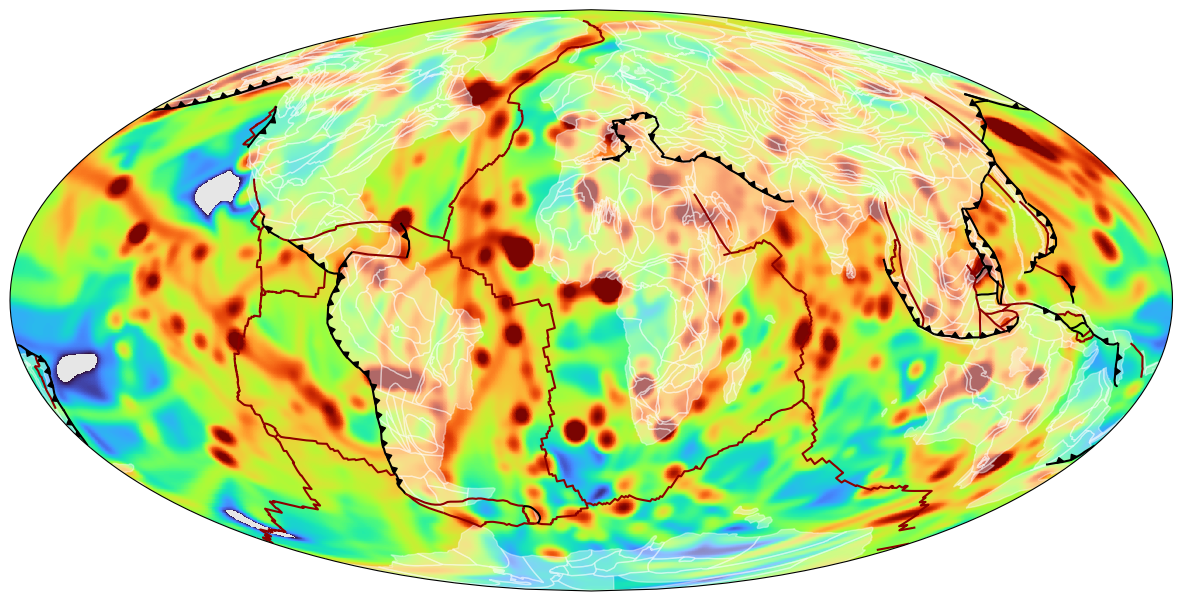

In [9]:
quantity = "mean"
reconstruction_time = 0
sample_grid = gplately.Raster(

    output_smooth_cumulative_subducted_carbon_filename.format(
         
        300,
        "Mantle", 
        quantity, 
        "Mantle".lower(), 
        reconstruction_time
    )
    
)

import copy 

proj = ccrs.Mollweide()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = sample_grid.data*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
lognorm_cmap.set_under(color='w', alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e4), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_continents(ax, facecolor='w', edgecolor='w', alpha=0.4, zorder=2)
gplot.plot_ridges(ax, color='DarkRed', linewidth=1.5, zorder=2)
gplot.plot_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

### Plotting a sample smoothed sediment grid

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_7564/2734080802.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


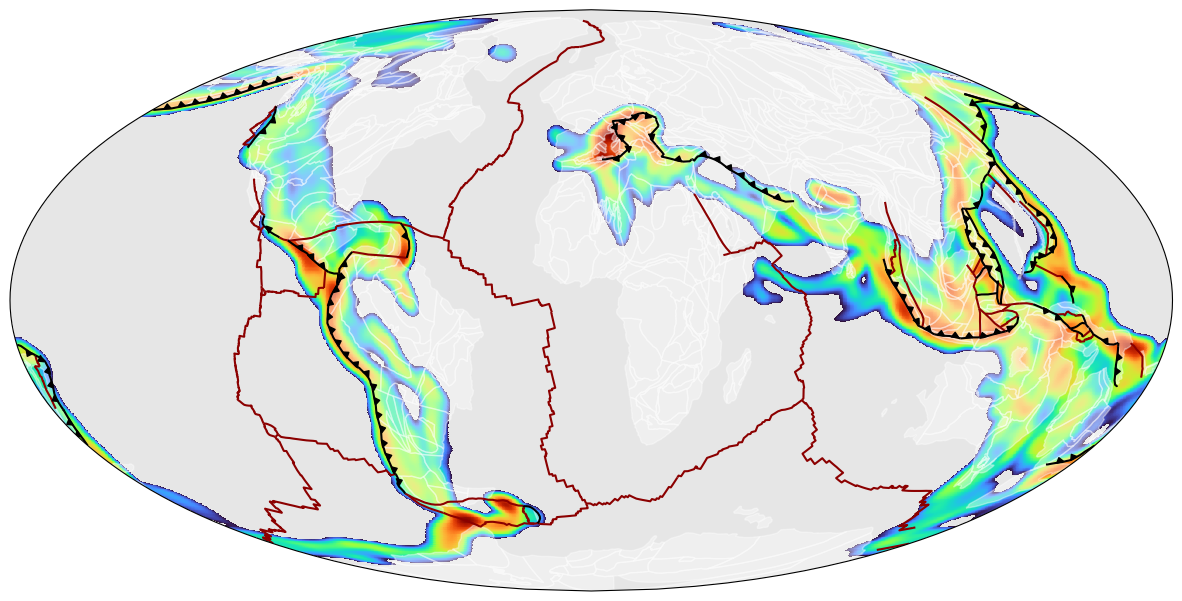

In [10]:
quantity = "mean"
reconstruction_time = 0
sample_grid = gplately.Raster(

    output_smooth_cumulative_subducted_carbon_filename.format(
         
        300,
        "Sediment", 
        quantity, 
        "Sediment".lower(), 
        reconstruction_time
    )
    
)

import copy 

proj = ccrs.Mollweide()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = sample_grid.data*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
lognorm_cmap.set_under(color='w', alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e3), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_continents(ax, facecolor='w', edgecolor='w', alpha=0.4, zorder=2)
gplot.plot_ridges(ax, color='DarkRed', linewidth=1.5, zorder=2)
gplot.plot_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

### Plotting a sample smoothed crustal carbon grid

In [ ]:
quantity = "mean"
reconstruction_time = 0
sample_grid = gplately.Raster(

    output_smooth_cumulative_subducted_carbon_filename.format(
         
        300,
        "Crust", 
        quantity, 
        "Crust".lower(), 
        reconstruction_time
    )
    
)

import copy 

proj = ccrs.Mollweide()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = sample_grid.data*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
lognorm_cmap.set_under(color='w', alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e3), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

### Plotting a sample smoothed organic sedimentary carbon grid

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_2782/1716705391.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


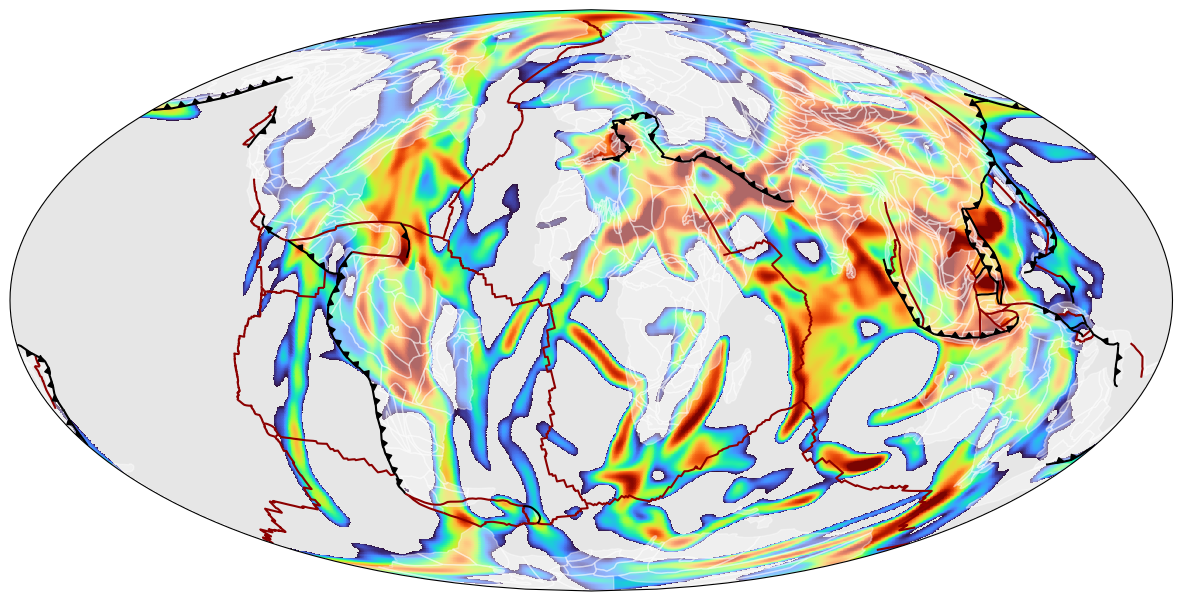

In [21]:
quantity = "mean"
reconstruction_time = 0
sample_grid = gplately.Raster(

    output_smooth_cumulative_subducted_carbon_filename.format(
         
        300,
        "Organic_Sediments", 
        quantity, 
        "Organic_Sediments".lower(), 
        reconstruction_time
    )
    
)

import copy 

proj = ccrs.Mollweide()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = sample_grid.data*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
lognorm_cmap.set_under(color='w', alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e2), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_continents(ax, facecolor='w', edgecolor='w', alpha=0.4, zorder=2)
gplot.plot_ridges(ax, color='DarkRed', linewidth=1.5, zorder=2)
gplot.plot_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)